In [43]:
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device
import torch



Using MPS (Apple Silicon GPU)


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Integer

columns = [
    'Stages', '_Lr1', '_Hr1',
    '_Lr2', '_Hr2', '_T_hex',
    '_Lr3', '_Hr3',
    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', 'Shortcut_Time',
    'Rigorous_CAPEX', 'Rigorous_OPEX', 'Rigorous_AceticAcidWt', 'Rigorous_Time'
]

# Create dataframe
results=pd.read_csv("/users/k23070952/MultiFidelity-ProcessOpt/3. Data/results_250327.csv")
results_df = pd.DataFrame(results.values, columns=columns)
results_df



,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,29.097983,0.192027,0.830914,0.534718,0.482652,339.477072,0.140696,0.269990,1.5784,3.4306,...,5.0,5.0,2.591851,1.0,1.0,0.740451,1.5139,3.5581,0.114924,18.185482
1873,43.540789,0.724463,0.783755,0.716127,0.635421,274.379108,0.397895,0.738708,1.4618,1.2144,...,11.0,9.0,0.364835,5.0,1.0,0.348606,1.3376,1.3866,0.270940,54.508650
1874,22.954292,0.489855,0.865933,0.490286,0.450705,293.290733,0.931610,0.538737,1.4599,1.7279,...,4.0,4.0,0.907706,7.0,1.0,0.413990,1.3949,1.8242,0.128783,49.467809
1875,38.446931,0.778869,0.509178,0.975166,0.714743,283.072326,0.983460,0.859721,2.0167,1.0236,...,23.0,16.0,0.190401,11.0,1.0,0.260442,1.8760,1.1823,0.999814,256.833613


R² Score: 0.1517 (1.0이면 완전 선형, 0에 가까울수록 비선형)


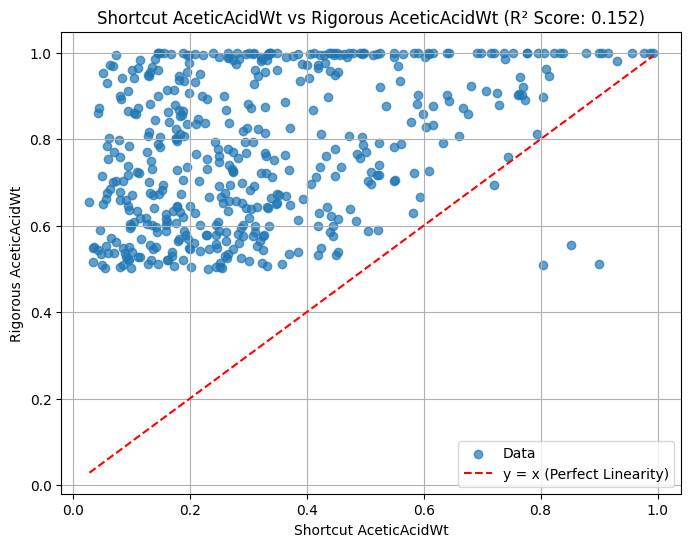

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filter out invalid or NaN results for CAPEX
valid_results = results_df.dropna(subset=['Shortcut_AceticAcidWt', 'Rigorous_AceticAcidWt'])
valid_results = valid_results[(valid_results['Shortcut_AceticAcidWt'] > 0) & (valid_results['Rigorous_AceticAcidWt'] > 0.5) &
                                (valid_results['Shortcut_AceticAcidWt'] < 1) & (valid_results['Rigorous_AceticAcidWt'] < 1)]

# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_AceticAcidWt'], valid_results['Rigorous_AceticAcidWt'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_AceticAcidWt'].min(), valid_results['Rigorous_AceticAcidWt'].min())
max_val = min(valid_results['Shortcut_AceticAcidWt'].max(), valid_results['Rigorous_AceticAcidWt'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_AceticAcidWt']].values
y = valid_results['Rigorous_AceticAcidWt'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut AceticAcidWt')
plt.ylabel('Rigorous AceticAcidWt')
plt.title(f'Shortcut AceticAcidWt vs Rigorous AceticAcidWt (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.1727 (1.0이면 완전 선형, 0에 가까울수록 비선형)


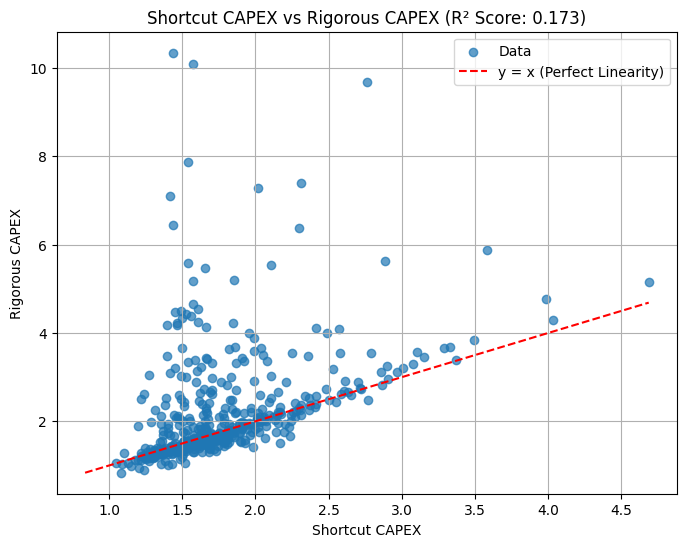

In [30]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_CAPEX'], valid_results['Rigorous_CAPEX'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_CAPEX'].min(), valid_results['Rigorous_CAPEX'].min())
max_val = min(valid_results['Shortcut_CAPEX'].max(), valid_results['Rigorous_CAPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_CAPEX']].values
y = valid_results['Rigorous_CAPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut CAPEX')
plt.ylabel('Rigorous CAPEX')
plt.title(f'Shortcut CAPEX vs Rigorous CAPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.9966 (1.0이면 완전 선형, 0에 가까울수록 비선형)


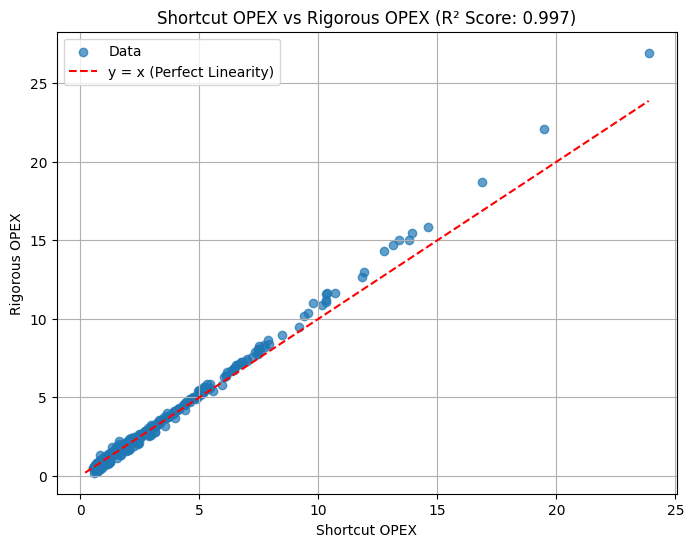

In [32]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_OPEX'], valid_results['Rigorous_OPEX'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_OPEX'].min(), valid_results['Rigorous_OPEX'].min())
max_val = min(valid_results['Shortcut_OPEX'].max(), valid_results['Rigorous_OPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_OPEX']].values
y = valid_results['Rigorous_OPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut OPEX')
plt.ylabel('Rigorous OPEX')
plt.title(f'Shortcut OPEX vs Rigorous OPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
valid_results

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,Shortcut_AceticAcidWt,Shortcut_BoilupRatio,Shortcut_SplitRatio,Shortcut_NumberStages,Shortcut_FeedStage,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,10.0,0.9500,0.9500,0.9500,0.95000,300.0,0.99990,0.95000,2.5601,0.7795,0.697454,2.871153,0.013807,22.0,17.0,4.599494,3.4224,0.8362,0.850190,16.926495
1,10.0,0.9500,0.9500,0.9500,0.95000,350.0,0.97495,0.99990,1.4485,0.8730,0.737271,4.809074,0.267223,10.0,8.0,4.847726,1.4810,0.9362,0.939633,34.737656
2,10.0,0.9500,0.9500,0.9500,0.95000,325.0,0.99990,0.97495,2.3886,0.6506,0.713874,3.166442,0.013807,22.0,17.0,4.480332,2.3961,0.6441,0.868548,38.693263
3,10.0,0.9500,0.9500,0.9500,0.95000,325.0,0.99990,0.95000,2.5664,0.6840,0.716334,3.171869,0.013807,22.0,17.0,4.398207,3.5395,0.6673,0.866484,38.833472
4,10.0,0.9500,0.9500,0.9500,0.95000,350.0,0.97495,0.97495,1.3558,0.7404,0.736039,4.820087,0.267071,10.0,8.0,4.421849,3.5445,0.7694,0.938321,49.551417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,50.0,0.9999,0.9999,0.9999,0.99990,350.0,0.95000,0.99990,2.1564,0.9132,0.999999,37.680021,0.328608,31.0,27.0,0.312009,303.0942,0.9660,0.758748,319.790068
3759,50.0,0.9999,0.9999,0.9999,0.99990,300.0,0.95000,0.95000,2.3781,0.9201,0.999999,36.948027,0.336296,31.0,26.0,0.287399,4.2286,1.0011,0.697695,549.564713
3760,50.0,0.9999,0.9999,0.9999,0.99990,325.0,0.95000,0.99990,2.1987,0.9119,0.999999,37.574357,0.332615,31.0,26.0,0.304128,4.3087,0.9442,0.727052,638.883610
3761,50.0,0.9999,0.9999,0.9999,0.95000,350.0,0.97495,0.95000,2.1301,0.8068,0.999999,36.613403,0.328604,31.0,27.0,0.526267,7.3234,0.7843,0.716087,1474.479994


## 1. 리그레이션 모델링


In [42]:
def prepare_data(df):
    input_cols = ['Stages', '_Lr1', '_Hr1', '_Lr2', '_Hr2', '_T_hex', '_Lr3', '_Hr3']

    target_cols = [
        'Rigorous_CAPEX'
    ]

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols

def prepare_data_add_shortcut(df):
    input_cols = [ 'Stages', '_Lr1', '_Hr1',
                    '_Lr2', '_Hr2', '_T_hex',
                    '_Lr3', '_Hr3',
                    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
                    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
                    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
                    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', ]
    
    target_cols = ['Rigorous_CAPEX']

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols


def run_linear_regression_with_validation(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        model = LinearRegression()
        model.fit(X_train, y_train[:, i])

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }

def run_random_forest_with_validation(X, y, test_size=0.4, random_state=1004):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    # Bayesian Optimization for hyperparameter tuning
    opt = BayesSearchCV(
        RandomForestRegressor(random_state=random_state),
        search_spaces={
            'n_estimators': Integer(50, 300),
            'max_depth': Integer(3, 15),
            'min_samples_leaf': Integer(1, 10),
        },
        n_iter=50,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    opt.fit(X_train, y_train[:, i])
    best_model = opt.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
    test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
    train_r2s.append(r2_score(y_train[:, i], y_train_pred))
    test_r2s.append(r2_score(y_test[:, i], y_test_pred))

    models.append(best_model)
    train_preds.append(y_train_pred)
    test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }



def run_xgboost_with_bayesian_optimization(X, y, test_size=0.2, random_state=1004, device='gpu', n_iter=200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        opt = BayesSearchCV(
            XGBRegressor(random_state=random_state, tree_method="hist", device=device, verbosity=0),
            search_spaces={
                'n_estimators': Integer(50, 300),
                'max_depth': Integer(3, 15),
                'min_child_weight': Integer(1, 10),
            },
            n_iter=n_iter,
            cv=5,
            scoring='neg_mean_squared_error',
            random_state=random_state,
            n_jobs=-1,
            verbose=1
        )
        opt.fit(X_train, y_train[:, i])
        best_model = opt.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(best_model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }


def plot_predictions_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                 target_cols, train_mse, train_r2, test_mse, test_r2,
                                 title="Model Prediction Results"):
    n_targets = len(target_cols)
    ncols = 3
    nrows = int(np.ceil(n_targets / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(n_targets):
        ax = axes[i]
        ax.scatter(y_train_true[:, i], y_train_pred[:, i], color='blue', alpha=0.6, label="Train")
        ax.scatter(y_test_true[:, i], y_test_pred[:, i], color='orange', alpha=0.6, label="Test")
        ax.plot([min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())],
                [min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())], 'r--')
        ax.set_title(f"{target_cols[i]}")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")

        ax.text(0.05, 0.95,
                f"Train MSE: {train_mse[i]:.3f}\nTrain R²: {train_r2[i]:.3f}\n"
                f"Test MSE: {test_mse[i]:.3f}\nTest R²: {test_r2[i]:.3f}",
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle="round", fc="white", alpha=0.5))
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_single_target_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                   target_name, train_mse, train_r2, test_mse, test_r2,
                                   title="Model Prediction Results"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, color='blue', alpha=0.6, label="Train")
    plt.scatter(y_test_true, y_test_pred, color='orange', alpha=0.6, label="Test")

    y_min = min(y_train_true.min(), y_test_true.min())
    y_max = max(y_train_true.max(), y_test_true.max())
    plt.plot([y_min, y_max], [y_min, y_max], 'r--')

    plt.title(f"{title}\nTarget: {target_name}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

    plt.text(0.05, 0.95,
             f"Train MSE: {train_mse:.3f}\nTrain R²: {train_r2:.3f}\n"
             f"Test MSE: {test_mse:.3f}\nTest R²: {test_r2:.3f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round", fc="white", alpha=0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

PCC 분석

In [51]:
def plot_correlation_matrix(df, title="Correlation Matrix"):
    corr = df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8},)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr


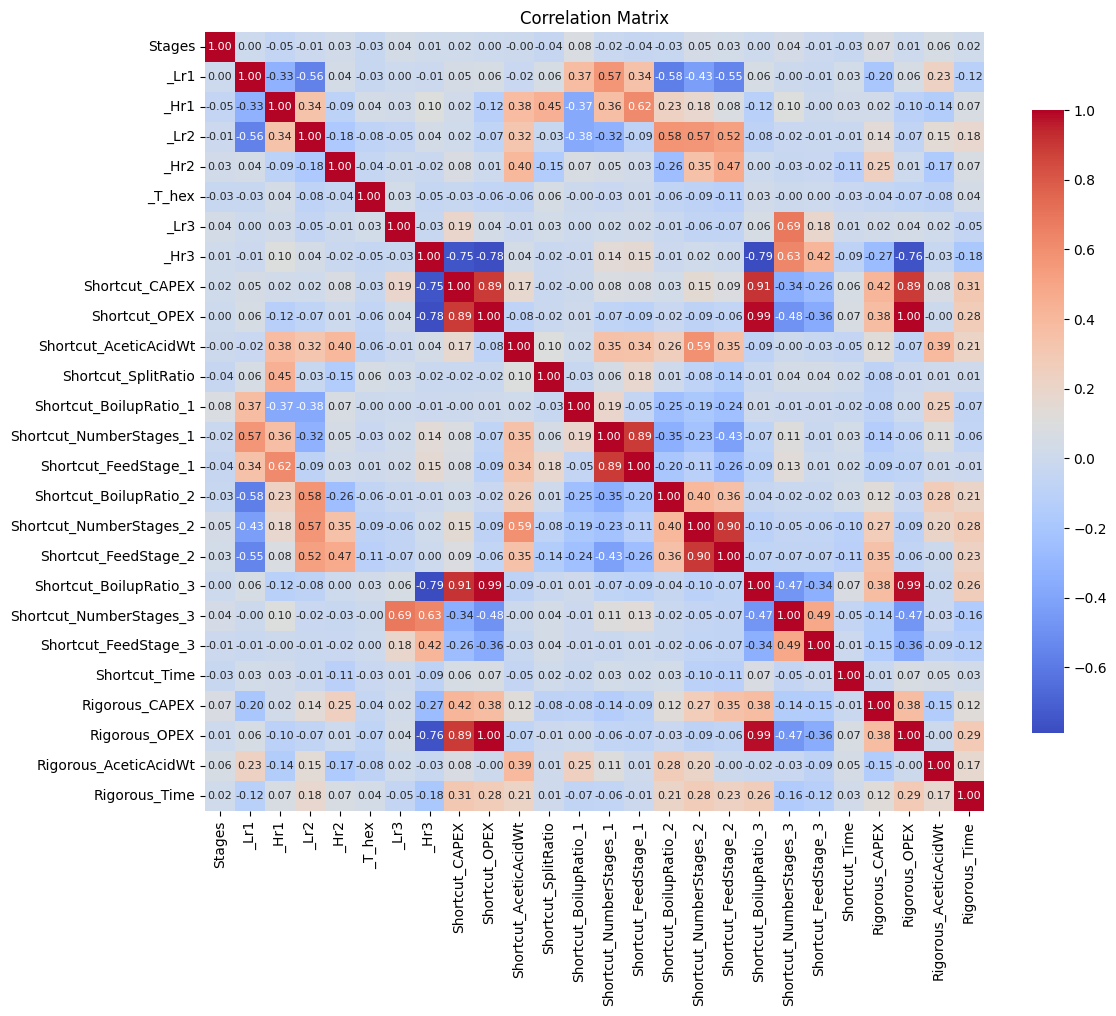

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
Stages,1.000000,0.001257,-0.054692,-0.012185,0.026067,-0.034124,0.038025,0.014622,0.020835,0.004607,...,0.045972,0.032641,0.002083,0.044716,-0.011193,-0.029690,0.074033,0.006076,0.060476,0.018646
_Lr1,0.001257,1.000000,-0.327205,-0.558949,0.038198,-0.033505,0.000822,-0.012007,0.053173,0.059700,...,-0.429642,-0.545117,0.059883,-0.002942,-0.013680,0.033217,-0.196245,0.059010,0.234156,-0.115146
_Hr1,-0.054692,-0.327205,1.000000,0.342490,-0.092265,0.039656,0.025051,0.100546,0.021521,-0.120383,...,0.178499,0.077342,-0.115982,0.099744,-0.000249,0.027533,0.022854,-0.098857,-0.144419,0.065984
_Lr2,-0.012185,-0.558949,0.342490,1.000000,-0.180329,-0.076854,-0.051377,0.036907,0.020486,-0.072436,...,0.570310,0.521448,-0.083473,-0.024875,-0.014008,-0.014556,0.137000,-0.069277,0.147057,0.180919
_Hr2,0.026067,0.038198,-0.092265,-0.180329,1.000000,-0.043392,-0.006179,-0.018778,0.076604,0.006248,...,0.348865,0.470216,0.001527,-0.031456,-0.021012,-0.108625,0.251513,0.005601,-0.166983,0.066044
_T_hex,-0.034124,-0.033505,0.039656,-0.076854,-0.043392,1.000000,0.031452,-0.046414,-0.033619,-0.060178,...,-0.089684,-0.105487,0.026267,-0.004260,0.003502,-0.027152,-0.043789,-0.072742,-0.084183,0.035911
_Lr3,0.038025,0.000822,0.025051,-0.051377,-0.006179,0.031452,1.000000,-0.033978,0.191680,0.038108,...,-0.064391,-0.067584,0.060063,0.686360,0.182912,0.011801,0.023090,0.035846,0.015764,-0.051556
_Hr3,0.014622,-0.012007,0.100546,0.036907,-0.018778,-0.046414,-0.033978,1.000000,-0.747549,-0.775629,...,0.018744,0.001884,-0.789446,0.634561,0.417986,-0.090258,-0.270866,-0.755510,-0.032113,-0.181571
Shortcut_CAPEX,0.020835,0.053173,0.021521,0.020486,0.076604,-0.033619,0.191680,-0.747549,1.000000,0.893939,...,0.148367,0.089718,0.912073,-0.337444,-0.262408,0.063020,0.415597,0.893168,0.075379,0.306819
Shortcut_OPEX,0.004607,0.059700,-0.120383,-0.072436,0.006248,-0.060178,0.038108,-0.775629,0.893939,1.000000,...,-0.090337,-0.060951,0.988686,-0.483020,-0.364842,0.066585,0.375343,0.998314,-0.001912,0.279835


In [52]:
plot_correlation_matrix(valid_results)

## Modelling-RF

In [ ]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data(data)

    # Linear Regression 실행
result = run_random_forest_with_validation(X, y)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Random Forest (Train/Test)"
)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

## Modelling-XGB

In [54]:
# XGBoost 실행
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data(data)
xgb_result = run_xgboost_with_bayesian_optimization(X, y)  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [36]:
y

array([ 1.0411,  2.1216,  3.3564,  1.6083,  4.9985,  0.7796,  1.6426,
        2.0584,  3.5415,  1.9983,  0.9419,  3.7745,  2.4439,  1.7506,
        2.5979,  0.8413,  0.9266,  0.8305,  0.9581,  1.3969,  0.5023,
        2.5345,  8.0784,  1.2348,  1.0617, 12.9642,  1.4446,  1.3113,
        1.3189,  3.7475,  1.6455,  2.5483,  3.3498,  2.1755,  4.3133,
        4.9209,  5.8431,  1.5813,  5.4984,  0.3166,  1.908 ,  1.3161,
        1.0752,  1.3341,  0.8173,  3.1432,  1.1257,  0.7724,  2.1078,
        0.8132,  5.4971,  2.2409,  1.1548,  0.7371,  1.3485,  7.8766,
        7.3   ,  1.8244,  1.8782,  1.3883, 10.3517,  1.0948,  0.3864,
        4.7105,  0.6877, 15.8619,  0.8758,  1.2879,  4.1769,  1.767 ,
        3.9532,  1.0477,  1.2014,  0.7387,  1.3556,  1.6391,  2.2057,
        2.1639,  1.0973,  0.9449,  1.6574,  0.9944,  4.9777,  1.3057,
        0.9477,  0.8362,  1.2852,  3.3595,  2.9547,  0.9453,  1.3121,
        0.5499, 11.5979,  5.6167,  3.5765,  3.0731,  1.8523,  1.4297,
        1.6082,  8.0

## Modelling-add Shortcut_OPEX

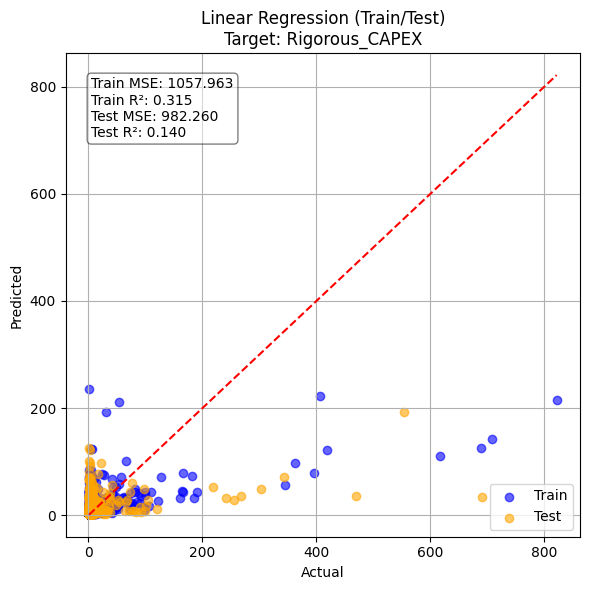

In [28]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)

    # Linear Regression 실행
result = run_random_forest_with_validation(X, y)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Linear Regression (Train/Test)"
)


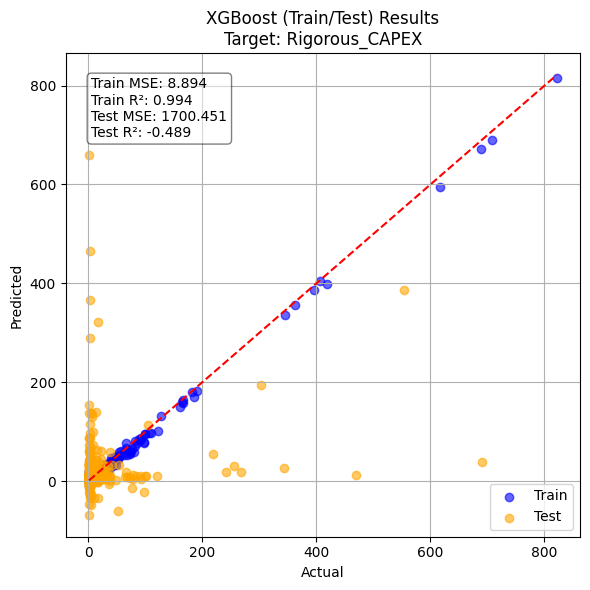

In [29]:
# XGBoost 실행
xgb_result = run_xgboost_with_validation(X, y, device='cpu')  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)